# Optimizing Model

## Scaler Impact for X- and Y- data

Both X and Y values are strongly unrelated due to various types of fillers (and polymers). Deep learning does not work well with high numbers. Normally the input features need encoding or scaling to small values. In general problems, the `MinMaxScaler` and `StandardScaler` are mostly used. However, in this project, the Scaler is very important to achieve convergent model.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import this module's functions
from functions import (
    map_num_to_string, map_string_to_num, sparse_array, early_stopper
    )

## Import data

In [2]:
file_name_all_data = "data/_nanocomposite_data.csv"
all_data = pd.read_csv(file_name_all_data, index_col=None, header=0)
# Drop columns which are not used for now
all_data_clean = all_data.drop(
    ["polymer_p2", "ratio_1_2", "filler_2", "wt_l2", "owner", "foaming"],
    axis=1,
)
all_data_clean = map_string_to_num(all_data_clean)

## Prepare Dataset for TensorFlow

### Scaling X and Y data
X data might not need scaling as the range of values is not high.

In [3]:
from functions import (
    SuperHighVariationScaler,
    SuperHighVariationScalerSimple,
    NoScaler,
)

### Splitting data to training and testing sets

In [4]:
training_data, testing_data = train_test_split(
    all_data_clean, test_size=0.2, random_state=25
    )

# Model build and complie

If you need more information about the Hyperparameter Tuning with the HParams, please refer to the following link:

https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

There are many other hyperparameters that can be tuned in that tutorial.

In [5]:
# Create function to build and compile model each run
def train_test_model(epochs=30):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(256, activation="relu", input_dim=3))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    model.compile(
        loss=tf.keras.losses.MeanAbsolutePercentageError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
        metrics=tf.keras.metrics.MeanSquaredLogarithmicError(),
    )

    model.fit(
        X_scaled_training,
        Y_scaled_training,
        epochs=epochs,
        batch_size=64,
        verbose=0,
        callbacks=[
            early_stopper(
                monitor="mean_squared_logarithmic_error",
                patience=50,
                verbose=0,
            )
        ],
    )

    _, MSLE = model.evaluate(X_scaled_testing, Y_scaled_testing, verbose=0)
    return model, MSLE

## Run GridSearch

We can try different values for both x and y scalers with different number of epoch.

In [6]:
X_scalers = [
    MinMaxScaler(feature_range=(0, 1)),
    SuperHighVariationScalerSimple(),
    SuperHighVariationScaler(NoScaler()),
]
Y_scalers = [
    MinMaxScaler(feature_range=(0, 1)),
    SuperHighVariationScalerSimple(),
    SuperHighVariationScaler(StandardScaler()),
]
epochs = [100, 300, 500]

best_MSLE = float("inf")
best_params = []
for i in range(len(X_scalers)):
    for j in range(len(Y_scalers)):
        for k in range(len(epochs)):
            X_scaler = X_scalers[i]
            Y_scaler = Y_scalers[j]
            epoch = epochs[k]

            # Split into input features (X) and output labels (Y) variables
            X_training = training_data.drop("conductivity", axis=1).values
            Y_training = training_data[["conductivity"]].values

            X_testing = testing_data.drop("conductivity", axis=1).values
            Y_testing = testing_data[["conductivity"]].values

            # Scale both the training inputs and outputs.
            X_scaled_training = X_scaler.fit_transform(X_training)
            Y_scaled_training = Y_scaler.fit_transform(Y_training)

            # Scaled with the same scaler.
            X_scaled_testing = X_scaler.transform(X_testing)
            Y_scaled_testing = Y_scaler.transform(Y_testing)

            model, MSLE = train_test_model(epoch)
            if MSLE < best_MSLE:
                best_MSLE = MSLE
                best_params = [i, j, k, model]

In [7]:
print("Best Mean Squared Logarithmic Error =", best_MSLE)
print("Best X scaler:", X_scalers[best_params[0]])
print("Best Y scaler:", Y_scalers[best_params[1]])
print("Best # of epoch:", epochs[best_params[2]])

Best Mean Squared Logarithmic Error = 0.005214526783674955
Best X scaler: MinMaxScaler()
Best Y scaler: SuperHighVariationScaler: StandardScaler()
Best # of epoch: 300


## Plotting predicting vs testing data

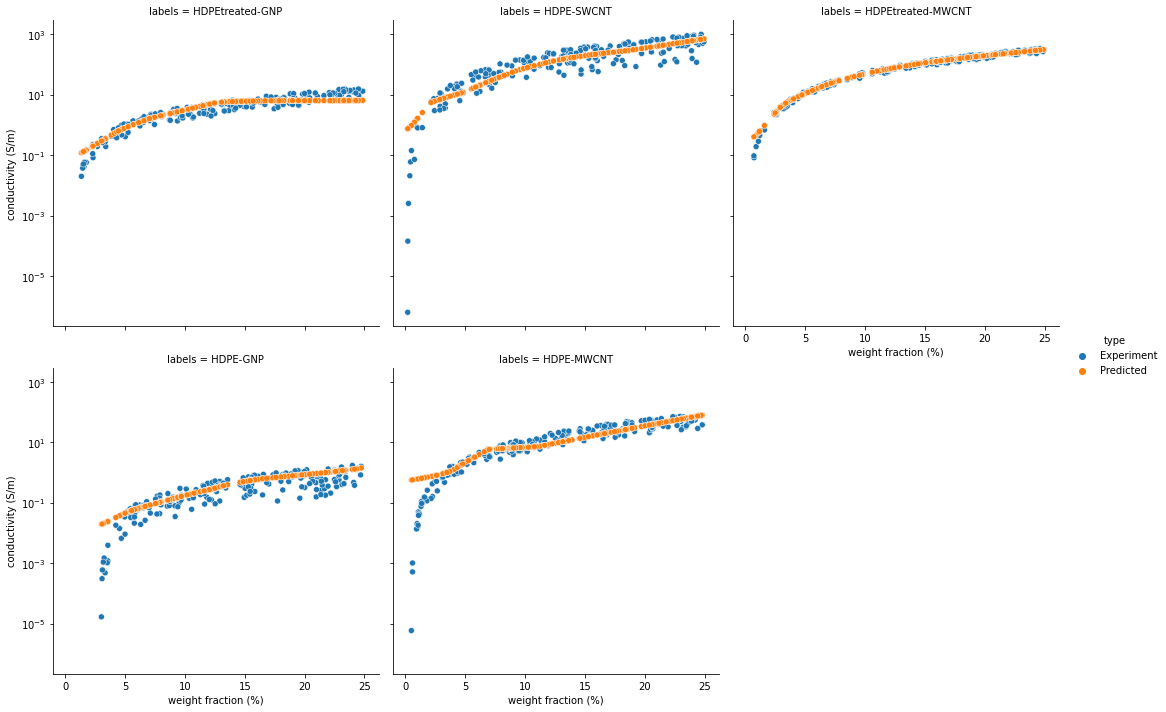

In [8]:
# Extract the best scalers from grid search results.
model = best_params[3]
X_scaler = X_scalers[best_params[0]]
Y_scaler = Y_scalers[best_params[1]]

# Calculate predictions
X_scaled_testing = X_scaler.transform(X_testing)

predicted_values = model.predict(X_scaled_testing)
predicted_values = Y_scaler.inverse_transform(predicted_values)

complete_data = testing_data.copy()
complete_data = map_num_to_string(complete_data)

complete_data["labels"] = (
    complete_data["polymer_1"] + "-" + complete_data["filler_1"]
)
complete_data["type"] = "Experiment"

other_data = complete_data.copy()
other_data["type"] = "Predicted"
other_data["conductivity"] = predicted_values

complete_data = pd.concat([complete_data, other_data], ignore_index=True)

g = sns.relplot(
    data=complete_data,
    x="wt_l1",
    y="conductivity",
    hue="type",
    col="labels",
    kind="scatter",
    col_wrap=3,
)
g.set_xlabels("weight fraction (%)")
g.set_ylabels("conductivity (S/m)")
g.set(yscale="log")
plt.show()

# Extrapolation: Estimate higher wt (>25%)

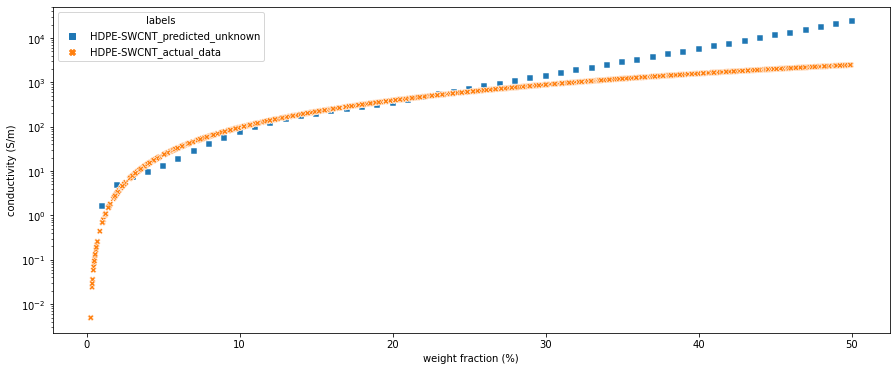

In [9]:
file_name_unknown_data_7 = "data-evaluation/HDPE_SWCNT_data-set-7.csv"
unknown_data_7 = pd.read_csv(
    file_name_unknown_data_7, index_col=None, header=0
)
unknown_data_7.drop(
    ["polymer_p2", "ratio_1_2", "filler_2", "wt_l2", "owner", "foaming"],
    axis=1,
    inplace=True,
)
unknowndata7_clean = unknown_data_7.copy()
unknowndata7_clean = map_string_to_num(unknowndata7_clean)
# Pull out columns for X (data to train with) and Y (value to predict)
X_unknown_data_7 = unknowndata7_clean.drop("conductivity", axis=1).values
X_scaled_unknowndata7 = X_scaler.transform(X_unknown_data_7)
# Calculate predictions
predicted_unknown_data_7 = model.predict(X_scaled_unknowndata7)
predicted_unknown_data_7 = Y_scaler.inverse_transform(predicted_unknown_data_7)
complete_data = unknown_data_7.copy()
complete_data["labels"] = (
    complete_data["polymer_1"]
    + "-"
    + complete_data["filler_1"]
    + "_predicted_unknown"
)
complete_data["conductivity"] = predicted_unknown_data_7

file_name_data_8 = "data-evaluation/HDPE_SWCNT_data-set-8.csv"
data8 = pd.read_csv(file_name_data_8, index_col=None, header=0)
data8["labels"] = data8["polymer_1"] + "-" + data8["filler_1"] + "_actual_data"

complete_data = pd.concat([complete_data, data8], ignore_index=True)

labels = complete_data["labels"].unique()  # get 2 labels in data set.

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
plt.xlabel("weight fraction (%)")
plt.ylabel("conductivity (S/m)")
plt.yscale("log")
g = sns.scatterplot(
    data=complete_data,
    x="wt_l1",
    y="conductivity",
    hue="labels",
    style="labels",
    ax=ax,
    markers={labels[0]: "s", labels[1]: "X"},
)
plt.show()

# Predicting unknow case - treated HDPE + SWCNT

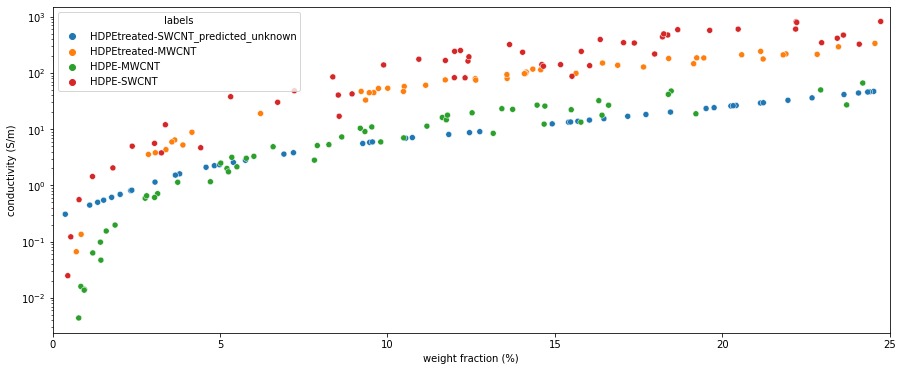

In [10]:
file_name_HDPEtreated_SWCNT = (
    "data-evaluation/HDPEtreated_SWCNT_data-set-6.csv"
)
data_HDPEtreated_SWCNT = pd.read_csv(
    file_name_HDPEtreated_SWCNT, index_col=None, header=0
)
data_HDPEtreated_SWCNT_clean = data_HDPEtreated_SWCNT.drop(
    ["polymer_p2", "ratio_1_2", "filler_2", "wt_l2", "owner", "foaming"],
    axis=1,
)
unknown_data = data_HDPEtreated_SWCNT_clean.copy()
unknown_data["conductivity"] = float("NaN")
unknown_data_clean = unknown_data.copy()
unknown_data_clean = map_string_to_num(unknown_data_clean)
# Pull out columns for X (data to train with) and Y (value to predict)
X_unknown_data = unknown_data_clean.drop("conductivity", axis=1).values
X_scaled_unknown_data = X_scaler.transform(X_unknown_data)
# Calculate predictions
predicted_unknown_data = model.predict(X_scaled_unknown_data)
predicted_unknown_data = Y_scaler.inverse_transform(predicted_unknown_data)

complete_data = unknown_data.copy()
complete_data["labels"] = (
    complete_data["polymer_1"]
    + "-"
    + complete_data["filler_1"]
    + "_predicted_unknown"
)
complete_data["conductivity"] = predicted_unknown_data

all_data["labels"] = all_data["polymer_1"] + "-" + all_data["filler_1"]

other_data = all_data[all_data["filler_1"] != "GNP"].copy()

complete_data = pd.concat([complete_data, other_data], ignore_index=True)

# reduce data rows to 5% (sparse data)
complete_data_subset = sparse_array(complete_data, 0.95)

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
plt.xlabel("weight fraction (%)")
plt.ylabel("conductivity (S/m)")
plt.yscale("log")
plt.xlim([0, 25])
g = sns.scatterplot(
    data=complete_data_subset, x="wt_l1", y="conductivity", hue="labels", ax=ax
)

# Conclusion

## Changing X-Scaler

Do not improve the Learning except strongly increasing `epochs`

## Y-Scaler

`MinMaxScaler` does not suitable for the fitting because of the discrepancy at low range of wt%, sometimes prediction is off range.

`StandardScaler` gives very good loss, but the issues are as same as `MinMaxScaler`.